# Capstone Project

Improving Life insurance direct marketing with Propensity Model

In [1730]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, StratifiedKFold,GridSearchCV
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import RFECV,SelectKBest,chi2, f_classif
import xgboost as xgb
from imblearn.combine import SMOTETomek

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score,auc, precision_score, precision_recall_curve,recall_score, f1_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import *
from sklearn.ensemble import RandomForestClassifier


In [1585]:
dataset = './caravan-insurance-challenge-2.csv'

In [1586]:
df = pd.read_csv(dataset)

In [1587]:
df.head()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0


# Steps for EDA

In this section, I explore the dataset provided. Several considerations can be made:

- The target varaible is binary, classification problem
- There are 86 predictors, none of which have informative headers
- There are over 9822 rows, 5822(train), 4000(test) 
- The percentage of positive responses is about 5%, suggesting a unbalanced dataset

In performing the exploratory analysis, I took the following steps:

- Renaming columns for easy interpretation
- Exploring relationships among variables
- Results and insights of this sections are reported in the subsections below


In [1588]:
df.rename(columns = {'MOSTYPE': 'subtype', 'MAANTHUI': 'num_of_houses','MGEMOMV': 'avg_size_household',
                    'MGEMLEEF': 'average_age', 'MOSHOOFD': 'maintype','MGODRK': 'catholic','MGODPR': 'protestant',
                    'MGODOV': 'other_religion','MGODGE': 'no_religion','MRELGE': 'married','MRELSA': 'liv_together',
                    'MRELOV': 'other_relationship', 'MFALLEEN': 'singles','MFGEKIND': 'no_child','MFWEKIND': 'with_child',
                    'MOPLHOOG': 'high_educ','MOPLMIDD': 'medium_educ','MOPLLAAG': 'low_educ','MBERHOOG': 'high_status',
                    'MBERZELF': 'entrepreneur','MBERBOER': 'farmer','MBERMIDD': 'mid_mgmt','MBERARBG': 'skill_labourer',
                    'MBERARBO': 'unskill_labourer','MSKA': 'social_classA','MSKB1': 'social_classB1','MSKB2': 'social_classB2',
                    'MSKC': 'social_classC','MSKD': 'social_classD','MHHUUR': 'not_homeowner','MHKOOP': 'homeowner',
                    'MAUT1': '1_car','MAUT2': '2_cars','MAUT0': 'no_car','MZFONDS': 'nation_health_services',
                    'MZPART': 'pte_health_ins','MINKM30': 'income_30','MINK3045': 'income_30_45','MINK4575': 'income_45_75',
                    'MINK7512': 'income_75_122','MINK123M': 'income_122','MINKGEM': 'average_income','MKOOPKLA': 'purchasing power class'}, inplace=True)


In [1589]:
# 2 groups that make the bulk of the columns which are different types of insurance premium and 
#the number of policies owned .
df.rename(columns = {

'PWAPART': 'third_party_premium',
'PWABEDR': 'company_premium',
'PWALAND': 'agri_premium',
'PPERSAUT':'car_premium',
'PBESAUT': 'van_premium',
'PMOTSCO': 'motorcycle_premium',
'PVRAAUT': 'lorry_premium',
'PAANHANG': 'trailer_premium',
'PTRACTOR': 'tractor_premium',
'PWERKT': 'agri_machines_premium',
'PBROM': 'moped_premium',
'PLEVEN': 'life_premium',
'PPERSONG': 'acc_premium',
'PGEZONG': 'fam_acc_premium',
'PWAOREG': 'disability_premium',
'PBRAND': 'fire_premium',
'PZEILPL': 'surfboard_premium',
'PPLEZIER': 'boat_premium',
'PFIETS': 'bicycle_premium',
'PINBOED': 'property_premium',
'PBYSTAND': 'social_security_premium',
'AWAPART': 'third_party_insurance',
'AWABEDR': 'company_insurance',
'AWALAND': 'agri_insurance',
'APERSAUT': 'car_insurance',
'ABESAUT': 'van_insurance',
'AMOTSCO': 'motorcycle_insurance',
'AVRAAUT': 'lorry_insurance',
'AAANHANG': 'trailer_insurance',
'ATRACTOR': 'tractor_insurance',
'AWERKT': 'agri_machines_insurance',
'ABROM': 'moped_insurance',
'ALEVEN': 'life_insurance',
'APERSONG': 'acc_insurance',
'AGEZONG': 'fam_acc_insurance',
'AWAOREG': 'disability_insurance',
'ABRAND': 'fire_insurance',
'AZEILPL': 'surfboard_insurance',
'APLEZIER': 'boat_insurance',
'AFIETS': 'bicycle_insurance',
'AINBOED': 'property_insurance',
'ABYSTAND': 'social_security_insurance'},inplace=True)


In [1590]:
# Target variable of life insurance, different number represent the number of policies owned 
# by an individual area code, but I am going to standardise those who bought a life insurance as 1 as 
# I will be predicting whether they will buy or not buy.

df['life_insurance'].value_counts()

0    9308
1     305
2     170
3      23
4      13
5       2
8       1
Name: life_insurance, dtype: int64

In [1591]:
df['life_insurance']  = df['life_insurance'].apply(lambda x: x if x == 0 else 1)

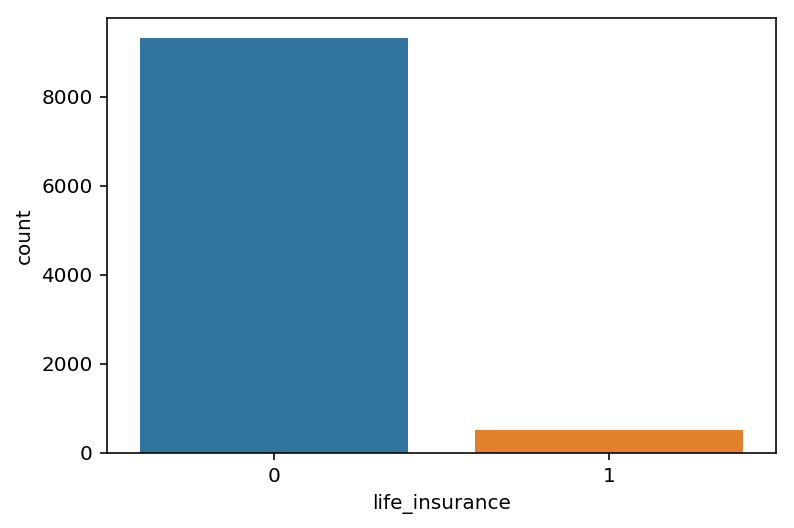

In [1592]:
# Target variable is quite inbalanced
sns.countplot(x = 'life_insurance', data = df)

In [1593]:
# Decided to create a new attribute of average income which will be more meaningful as 
#there is only 1 household per row

In [1594]:
income = df[['income_30', 'income_30_45', 'income_45_75', 'income_75_122','income_122']]

In [1595]:
# Mapping the Ordinal data into values in percentage 
def income_conversion(num):
    income_dict= {0 : 0, 1 : .05, 2 : .17, 3 : .30, 4 : .43, 5 : .56, 6 : .69, 7 : .84, 8 : .94, 9 : 1.0}
    return income_dict[num]



In [1596]:
income = income.applymap(income_conversion)

In [1597]:
# I find the average of each income range and multiple to the percentage.

income.loc[:,'income_30'] *= 15000
income.loc[:,'income_30_45'] *= 37500
income.loc[:, 'income_45_75']*= 60000
income.loc[:, 'income_75_122'] *= 97500
income.loc[:,'income_122'] *= 120000

In [1598]:
#Finally Sum up the 5 columns to get the average income for each instance
income['average_salary'] = income.sum(axis = 1)

In [1599]:
df= pd.concat([income['average_salary'], df], axis=1, join='inner').drop(columns= 'average_income')

In [1600]:
# Imputing the average age with average of a range of value, eg 25 instead of 20-30.
df['average_age'] = df['average_age'].map({1: 25, 2: 35, 3: 45, 4: 55, 5: 65, 6: 75})

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'number of houses vs average size per household')

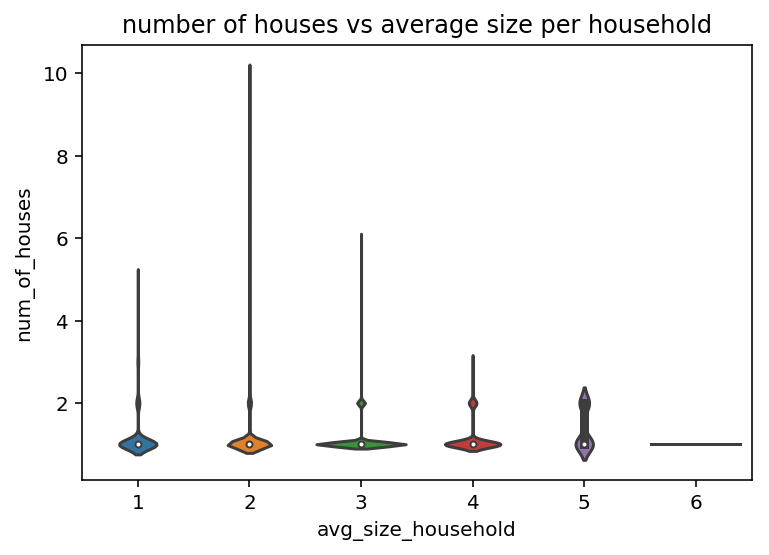

In [1601]:
#Notice that regardless how big the average household is, most of the distribution falls within 1 number of houses.
#Also average size household of 3 has the largest distribution, my assumption is most of them are couple with 1 child,
# or small families.
sns.violinplot('avg_size_household', 'num_of_houses', data = df, kind='scatter').set_title('number of houses vs average size per household')



In [1602]:
# Aftr examining the number of houses per area code, notice most of them have only 1 house so i decide to remove the rest.
df = df[df['num_of_houses']== 1]
df.shape

(8915, 87)

Text(0.5, 1.0, 'Relationship between Age and Salary')

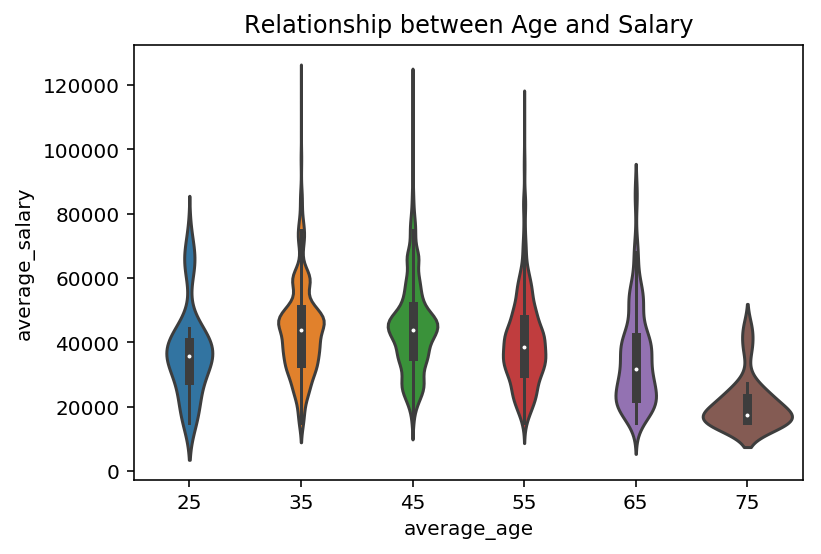

In [1603]:
sns.violinplot(x = 'average_age', y = 'average_salary', data =df).set_title('Relationship between Age and Salary')

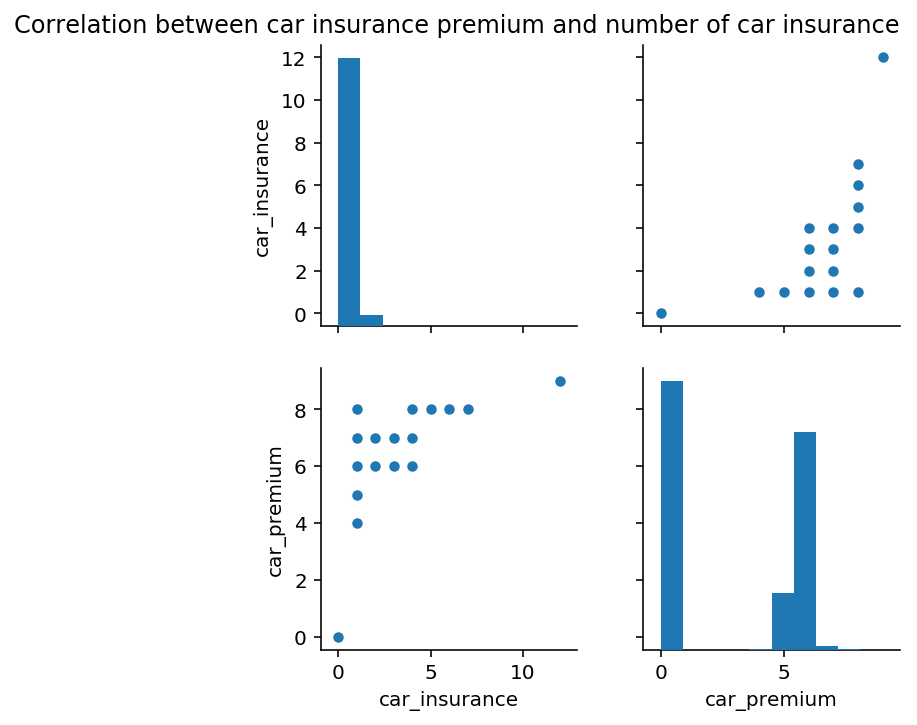

In [1654]:
# Most of the insurance premium and number of insurance owned are highly correlated, which is quite logical 
# so i will remove the insurance premium columns in the modelling part to prevent multicollinearity. 
sns.pairplot(vars= ['car_insurance', 'car_premium'], data = df)
plt.title('Correlation between car insurance premium and number of car insurance', loc='right')
plt.show()

In [1605]:
df_has_ins = df.loc[df['life_insurance']!=0]

In [1606]:
df_has_ins['life_insurance'].replace({1: 'yes'}, inplace= True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Text(0.5, 1.0, 'average age distribution')

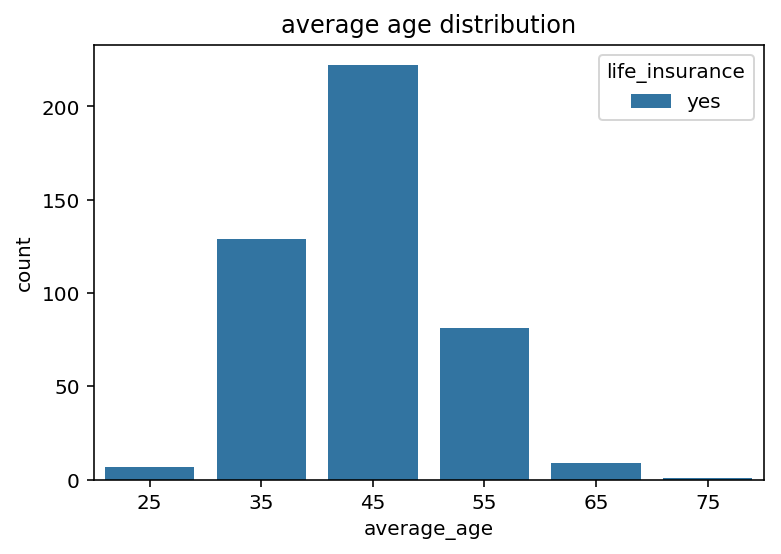

In [1607]:
# Those in the age of 45 and 35 tends to buy more life insurance which sense as they need the income protection. 

sns.countplot(data = df_has_ins, x= 'average_age', hue= 'life_insurance').set_title('average age distribution')

In [1608]:
maintype_conversion = {1: 'Successful hedonists', 2: 'Driven Growers', 3: 'Average Family', 4: 'Career Loners',
                       5: 'Living well', 6: 'Cruising Seniors', 7: 'Retired and Religeous', 8: 'Family with grown ups', 
                       9: 'Conservative families' ,10: 'Farmers'}
df_has_ins['maintype'] = df_has_ins['maintype'].map(maintype_conversion)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


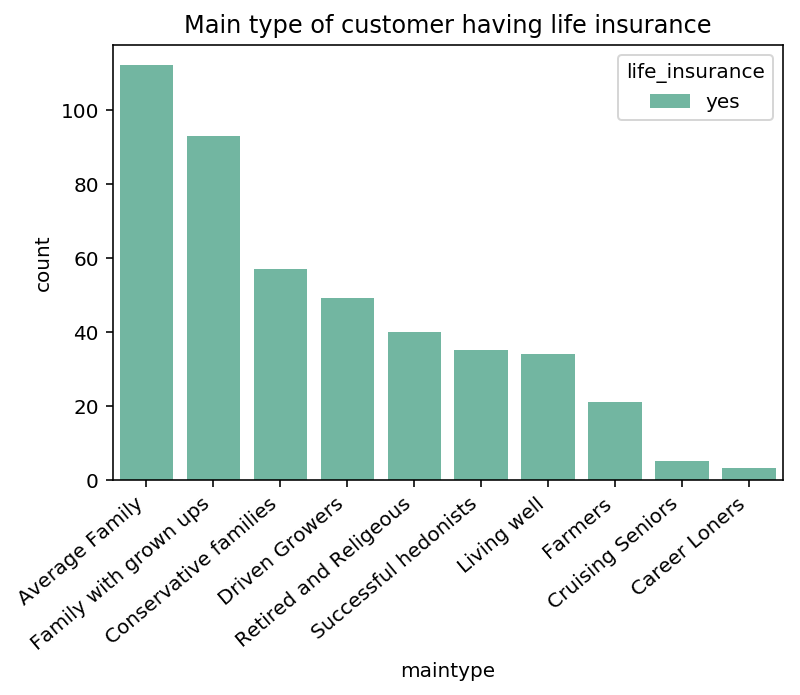

In [1609]:
ax = sns.countplot(x = 'maintype', data = df_has_ins, order =  df_has_ins['maintype'].value_counts().index, 
                   hue = 'life_insurance', palette = 'Set2', orient ='h')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha= 'right')
plt.title('Main type of customer having life insurance')


plt.show()

In [1610]:
df_target = df['life_insurance'].replace({1: 'yes', 0: 'No'})


Text(0.5, 1.0, 'Distribution of household who purchased a life insurance')

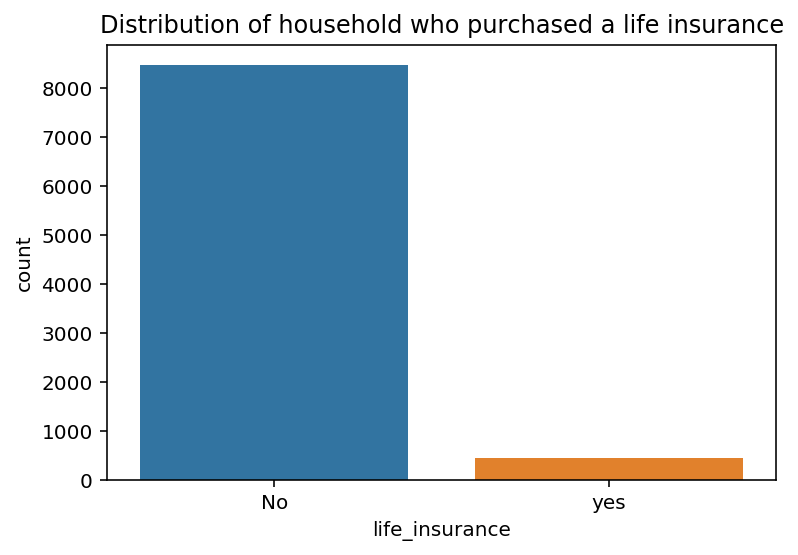

In [1611]:
# Target variable is quite inbalanced
sns.countplot(df_target).set_title('Distribution of household who purchased a life insurance')


In [1612]:
# I will be dividing the cat_attributes to convert to dummy variables and num_attributes to do features selection
#using SelectKbest

cat_attributes = df[['subtype','maintype']]
num_attributes = df.drop(columns= ['subtype','maintype','ORIGIN','CARAVAN','income_30', 'income_30_45', 'income_45_75', 
                          'income_75_122','income_122','life_insurance','third_party_premium','company_premium',
                          'agri_premium','car_premium','van_premium','motorcycle_premium',
                            'lorry_premium','trailer_premium','tractor_premium','agri_machines_premium',
                            'moped_premium','life_premium','acc_premium','fam_acc_premium','disability_premium',
                            'fire_premium','surfboard_premium','boat_premium','bicycle_premium','property_premium'
                            ,'social_security_premium', 'num_of_houses']).astype(float)

In [1613]:
dummy_cat_attributes =pd.get_dummies(cat_attributes,columns=['subtype','maintype'])



In [ ]:
print(num_attributes.shape)
print(dummy_cat_attributes.shape)

In [1615]:
#Performing feature selection using selectkbest to select 20 features from the 55 features

skb = SelectKBest(score_func=chi2, k=20)
X_selected = skb.fit(num_attributes, y)
features = sorted(zip(skb.scores_, num_attributes.columns), reverse=True)
print(num_attributes.columns[skb.get_support()])

Index(['average_salary', 'singles', 'high_educ', 'medium_educ', 'low_educ',
       'high_status', 'unskill_labourer', 'social_classA', 'social_classC',
       'no_car', 'pte_health_ins', 'purchasing power class',
       'third_party_insurance', 'car_insurance', 'motorcycle_insurance',
       'moped_insurance', 'fam_acc_insurance', 'fire_insurance',
       'property_insurance', 'social_security_insurance'],
      dtype='object')


In [1616]:
# 20 Features selected to use in the modelling
num_attributes = num_attributes[['average_salary', 'average_age', 'liv_together', 'other_relationship',
       'singles', 'high_educ', 'medium_educ', 'low_educ', 'high_status',
       'farmer', 'mid_mgmt', 'unskill_labourer', 'social_classA',
       'social_classC', 'social_classD', '1_car', 'no_car',
       'nation_health_services', 'pte_health_ins', 'purchasing power class',
       'third_party_insurance', 'car_insurance', 'motorcycle_insurance',
       'moped_insurance', 'acc_insurance', 'fam_acc_insurance',
       'disability_insurance', 'fire_insurance', 'property_insurance',
       'social_security_insurance']].astype(float)


In [1617]:
#Merging the cat_attributes and num_attributes
X = pd.concat([num_attributes, dummy_cat_attributes], axis=1, sort=False)

In [1618]:
y = df['life_insurance'].values

In [1619]:
# function to calculate the performance of each model in the later part.

def performance_metrics(Accuracy, Precision, Recall, F1, AUC):
    print('Accuracy           '+"{:.2f}".format(np.mean(Accuracy)*100)+'%')
    print('Precision          '+"{:.2f}".format(np.mean(Precision)*100)+'%')
    print('Recall             '+"{:.2f}".format(np.mean(Recall)*100)+'%')
    print('F1                 '+"{:.2f}".format(np.mean(F1)))
    print('AUC                '+"{:.2f}".format(np.mean(AUC)))

In [1646]:
#function to plot the ROC-curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=(label + ' (area = %0.2f)' % roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve')



In [1643]:
# Function to plot the precision, recall vs threshold curve to find the optimal precision and recall
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.axvline(x=0.5, linewidth=0.25, color='k')
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.title('Precision Recall Vs Threshold curve')

    plt.ylim([0, 1])

In [1638]:
# function to plot the confusion matrix

def plot_confusion_matrix(conf_mat,y_test, y_pred, model):
    plt.imshow(conf_mat,interpolation='nearest', cmap=plt.cm.Pastel2)
    classNames = ['Does not Buy','Buy ']
    plt.title('{} Confusion Matrix'.format(model))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(conf_mat[i][j]))
    plt.show()

In [1623]:
#function to calculate the cost and benefit amount 
def calculate_profit(conf_mat, TN_amount, FN_amount, FP_amount, TP_amount):
    
    return (conf_mat[0][0]*TN_amount + conf_mat[1][0]*FN_amount + conf_mat[0][1]*FP_amount +
                   conf_mat[1][1]*TP_amount)

In [1624]:
# I want to find out in an marketing campaign, what is the profit/loss given the premium amount, marketing cost 
# and the 2971 test data.   

def create_ranking_profit_df(name, y_actual, y_proba):
    df_scores = pd.DataFrame({'score': y_proba[:,1],
                              'actual': y_actual})
    
    df_scores = df_scores.sort_values("score", ascending = False)
    df_scores["profit"] = (TP_amount - FP_amount) * df_scores["actual"] + FP_amount
    df_scores["cummulative_profit"] = df_scores["profit"].cumsum(axis = 0)
    
    return df_scores

In [1625]:
# Function to plot the cummulative profit with the the number of test instances.

def plot_profit_curve(name, df_scores):
    plt.plot(df_scores["cummulative_profit"].values, linewidth=1, label=name + " Profit curve")
    plt.plot([0, 0], [0, 1], 'k--')
    plt.legend(loc="lower left")
    plt.xlabel('Number of test instances', fontsize=16)
    plt.ylabel('Profit', fontsize=16)
    plt.grid(True)

In [1626]:
# I will be running 5 different model to have a good comparison on the result. In order to prevent overfitting,
# i will be using stratified kfold and with smotetomek to increase the sample of the minority class and
# cleaning using Tomek links
#Steps to take -MinMaxScaler on the predictor features
#              - StratifiedKfold
#              -Train test split 
#              -Smotetomek on training data
#              -Test on the untouched test data.

# Random Forest

In [1648]:
# Using minmaxscaler to scale the features
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)

Accuracy = []
Precision=[]
Recall=[]
F1 = []
AUC = []

rf = RandomForestClassifier(bootstrap=True,
                            criterion='gini', max_depth=3,min_impurity_split=None,min_samples_split=0.1,
                            n_estimators=100,random_state=42)    
kf = StratifiedKFold(n_splits=3)                                                                          
for train_index, test_index in kf.split(Xs,y):
    smt = SMOTETomek(ratio = 'auto')
    X_train_smt, y_train_smt = smt.fit_sample(Xs[train_index], y[train_index])
    
    rf.fit(X_train_smt, y_train_smt) 
    
    pred = rf.predict(Xs[test_index])
    pred_proba = rf.predict_proba(Xs[test_index])  
    
    fpr, tpr, thresholds = roc_curve(y[test_index], pred_proba[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    conf_mat = confusion_matrix(y[test_index], pred)


    
    Accuracy.append(accuracy_score(y[test_index], pred))
    Precision.append(precision_score(y[test_index], pred))
    Recall.append(recall_score(y[test_index], pred))
    F1.append(f1_score(y[test_index], pred))
    AUC.append(roc_auc_score(y[test_index], pred_proba[:,1]))


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [1649]:
performance_metrics(Accuracy, Precision, Recall, F1, AUC)


Accuracy           76.85%
Precision          10.31%
Recall             46.77%
F1                 0.17
AUC                0.69


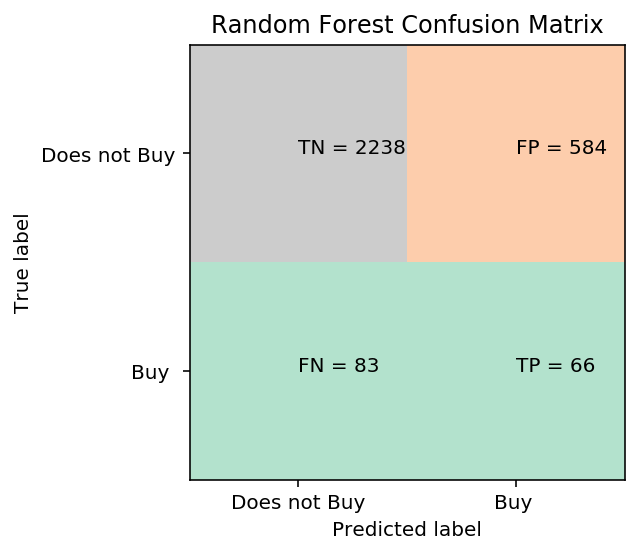

In [1650]:
plot_confusion_matrix(conf_mat, y[test_index], pred, "Random Forest")

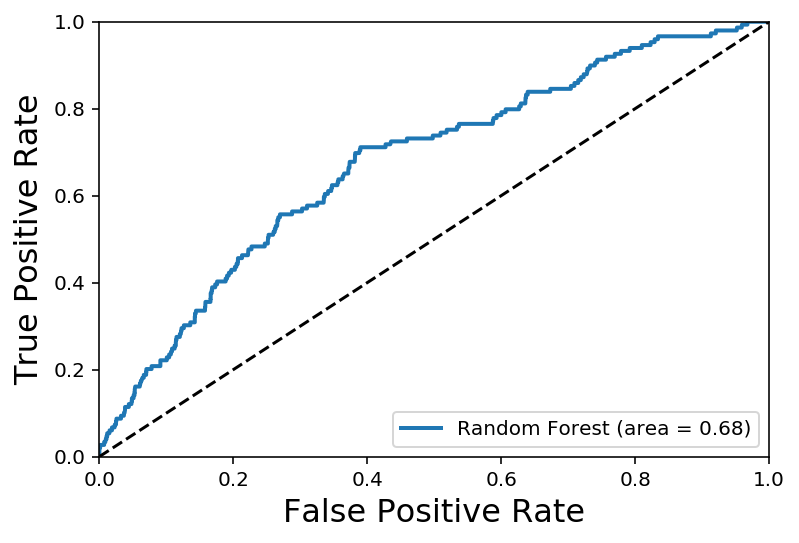

In [1571]:
plot_roc_curve(fpr, tpr, "Random Forest")

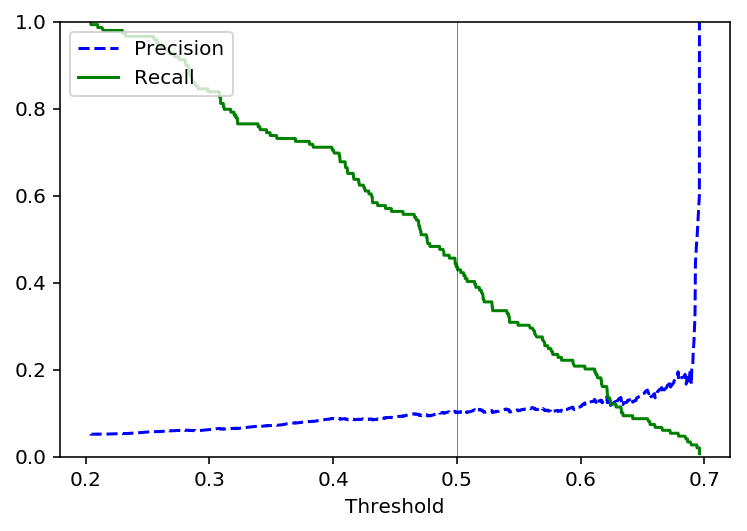

In [1572]:
precisions, recalls, thresholds = precision_recall_curve(y[test_index], pred_proba[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [1573]:
# Seems like the top 3 features that contribute to the AUC of 0.67 is fire insurance, car insurance and third party insurance


In [1574]:
rf_feature_importances_ = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)

rf_feature_importances_.head(5)

,Importance
fire_insurance,0.209602
third_party_insurance,0.205604
car_insurance,0.160366
liv_together,0.063365
high_status,0.054573


# XGBoost



In [1655]:
Accuracy = []
Precision=[]
Recall=[]
F1 = []
AUC = []

xgboost = xgb.XGBClassifier(random_state=42)    
                                                                                                
kf = StratifiedKFold(n_splits=3)                                                                          
for train_index, test_index in kf.split(Xs,y):
    smt = SMOTETomek(ratio = 'auto')
    X_train_smt, y_train_smt = smt.fit_sample(Xs[train_index], y[train_index])
    
    xgboost.fit(X_train_smt, y_train_smt) 
    
    pred = xgboost.predict(Xs[test_index])
    pred_proba =xgboost.predict_proba(Xs[test_index])  
    
    fpr, tpr, thresholds = roc_curve(y[test_index], pred_proba[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    conf_mat = confusion_matrix(y[test_index], pred)
    
    Accuracy.append(accuracy_score(y[test_index], pred))
    Precision.append(precision_score(y[test_index], pred))
    Recall.append(recall_score(y[test_index], pred))
    F1.append(f1_score(y[test_index], pred))
    AUC.append(roc_auc_score(y[test_index], pred_proba[:,1]))

In [1656]:
performance_metrics(Accuracy, Precision, Recall, F1, AUC)

Accuracy           94.04%
Precision          17.96%
Recall             5.56%
F1                 0.08
AUC                0.72


In [1657]:
# Although XGboost is achieved better AUC score but the recall and precision score are quite bad. 

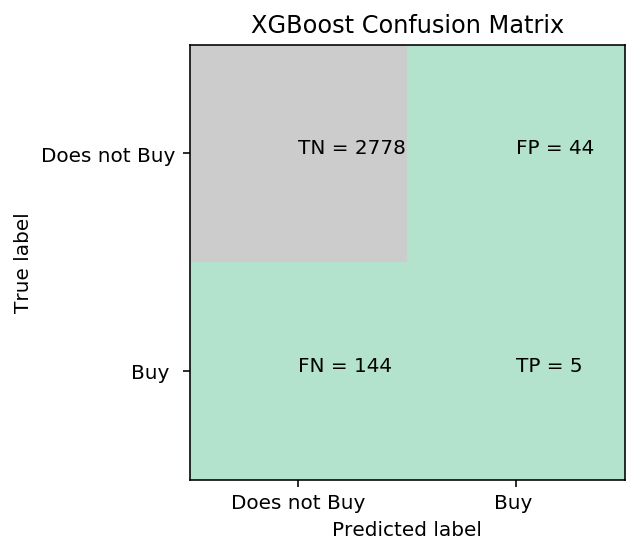

In [1658]:
plot_confusion_matrix(conf_mat,y[test_index], pred, "XGBoost")

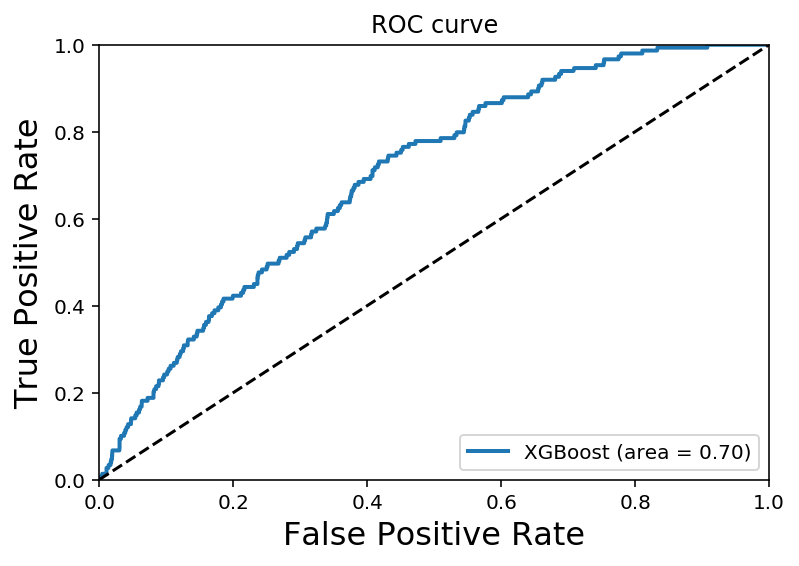

In [1659]:
plot_roc_curve(fpr, tpr, "XGBoost")

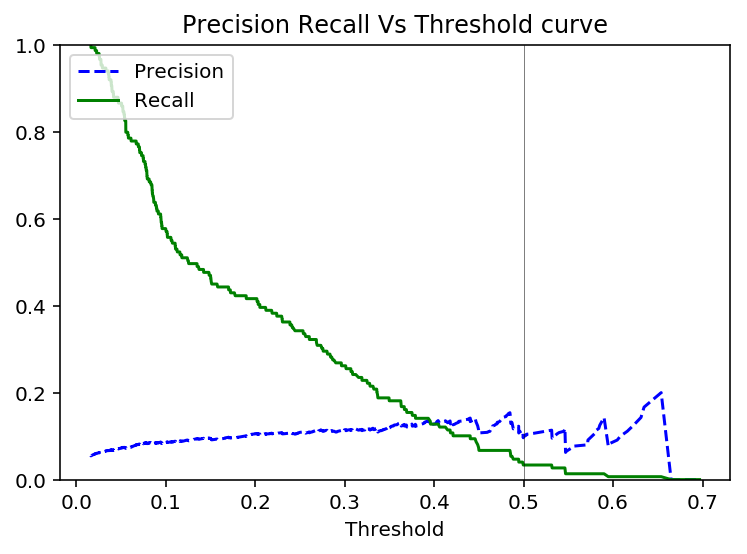

In [1660]:
precisions, recalls, thresholds = precision_recall_curve(y[test_index], pred_proba[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [1661]:
#There are 2 features that are similar to random forest except for those who are single also contribute to the
#accuracy of the model.


In [1662]:
xgb_feature_importances_ = pd.DataFrame(xgboost.feature_importances_,
                                   index = X.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)

xgb_feature_importances_.head()

,Importance
car_insurance,0.169279
fire_insurance,0.076803
average_age,0.067398
liv_together,0.056426
1_car,0.045455


# Decision Tree

In [1663]:
Accuracy = []
Precision=[]
Recall=[]
F1 = []
AUC = []

kf = KFold(n_splits=3)                                                                          
dt = DecisionTreeClassifier(criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')    
                                                                                                
for train_index, test_index in kf.split(Xs,y):
    smt = SMOTETomek(ratio = 'auto')
    X_train_smt, y_train_smt = smt.fit_sample(Xs[train_index], y[train_index])
    
    dt.fit(X_train_smt, y_train_smt) 
    
    pred = dt.predict(Xs[test_index])
    pred_proba = dt.predict_proba(Xs[test_index])  
    
    fpr, tpr, thresholds = roc_curve(y[test_index], pred_proba[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    conf_mat = confusion_matrix(y[test_index], pred)
    
    Accuracy.append(accuracy_score(y[test_index], pred))
    Precision.append(precision_score(y[test_index], pred))
    Recall.append(recall_score(y[test_index], pred))
    F1.append(f1_score(y[test_index], pred))
    AUC.append(roc_auc_score(y[test_index], pred_proba[:,1]))

In [1664]:
performance_metrics(Accuracy, Precision, Recall, F1, AUC)

Accuracy           75.15%
Precision          10.63%
Recall             52.62%
F1                 0.18
AUC                0.67


In [1665]:
#Recall seems ok but poor in precision.

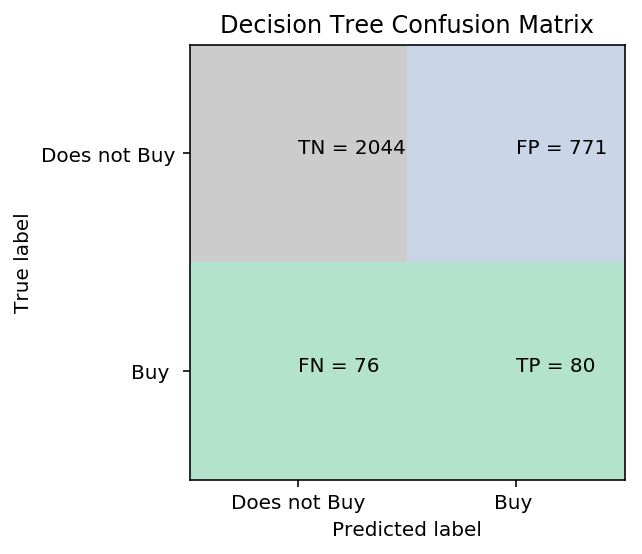

In [1666]:
plot_confusion_matrix(conf_mat,y[test_index], pred, "Decision Tree")

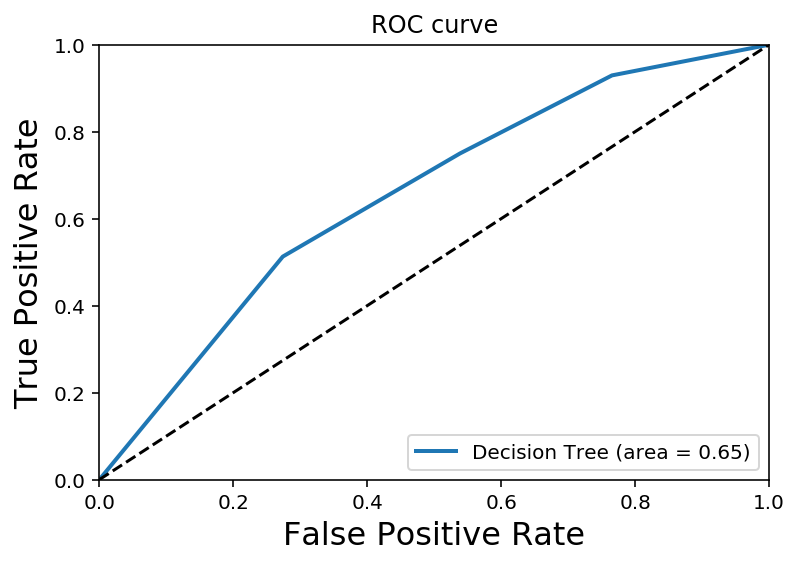

In [1667]:
plot_roc_curve(fpr, tpr, "Decision Tree")

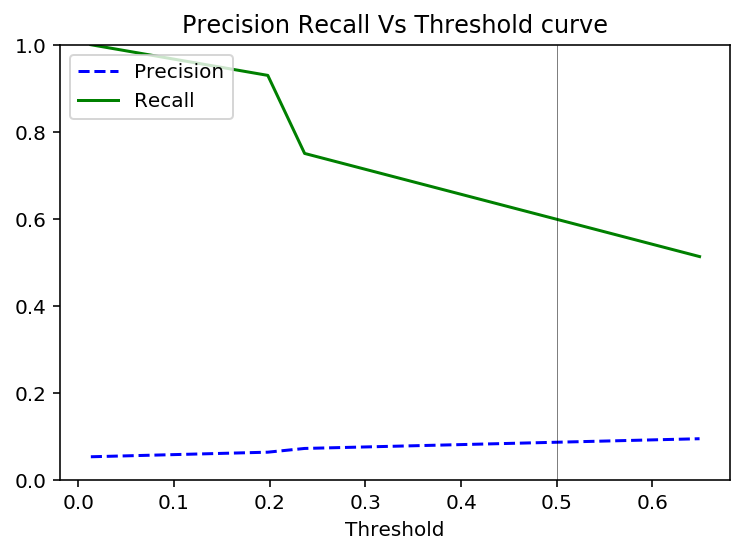

In [1668]:
precisions, recalls, thresholds = precision_recall_curve(y[test_index], pred_proba[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [1669]:
# Decision come with the same conclusion with the above 2 models, subtype 33,34 and 36 are 36 are families with 
# children. This make sense as this group of customer tends to buy life insurance to protect themselves against loss
# of income in the event of premature death.

In [1670]:
dt_feature_importances_ = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)

dt_feature_importances_.head()

,Importance
car_insurance,0.500839
fire_insurance,0.499161
subtype_12,0.000000
subtype_31,0.000000
subtype_30,0.000000


# Support Vector Machine

In [1671]:
Accuracy = []
Precision=[]
Recall=[]
F1 = []
AUC = []


svm = SVC(C=1.0,decision_function_shape='ovr', degree=3, gamma='scale',
              kernel='linear', probability=True,random_state=42, tol=0.001)    
    
kf = KFold(n_splits=2)                                                                          
                                                                          
for train_index, test_index in kf.split(Xs,y):
    smt = SMOTETomek(ratio = 'auto')
    X_train_smt, y_train_smt = smt.fit_sample(Xs[train_index], y[train_index])
    
    svm.fit(X_train_smt, y_train_smt)
    
    pred = svm.predict(Xs[test_index])
    pred_proba = svm.predict_proba(Xs[test_index])  
    
    fpr, tpr, thresholds = roc_curve(y[test_index], pred_proba[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    conf_mat = confusion_matrix(y[test_index], pred)

    Accuracy.append(accuracy_score(y[test_index], pred))
    Precision.append(precision_score(y[test_index], pred))
    Recall.append(recall_score(y[test_index], pred))
    F1.append(f1_score(y[test_index], pred))
    AUC.append(roc_auc_score(y[test_index], pred_proba[:,1]))

In [1672]:
performance_metrics(Accuracy, Precision, Recall, F1, AUC)

Accuracy           66.67%
Precision          8.66%
Recall             58.58%
F1                 0.15
AUC                0.66


In [1673]:
# Support Vector machine give the best recall, able to produce quite a good recall which means those customer who 
#will buy the life insurance.

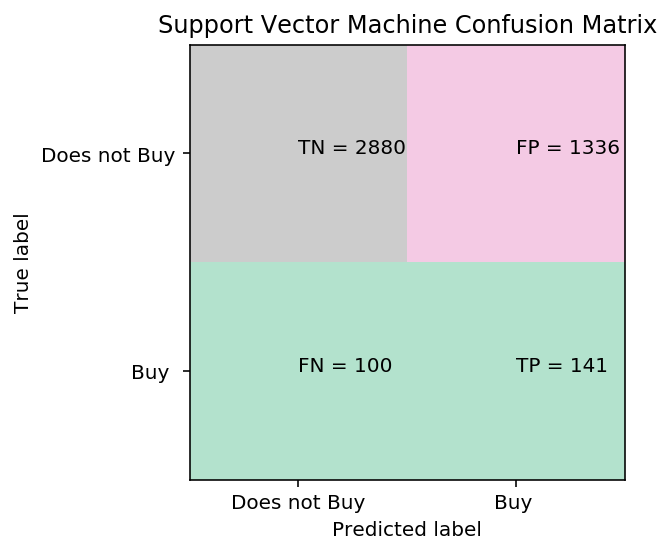

In [1674]:
plot_confusion_matrix(conf_mat, y[test_index], pred, "Support Vector Machine")

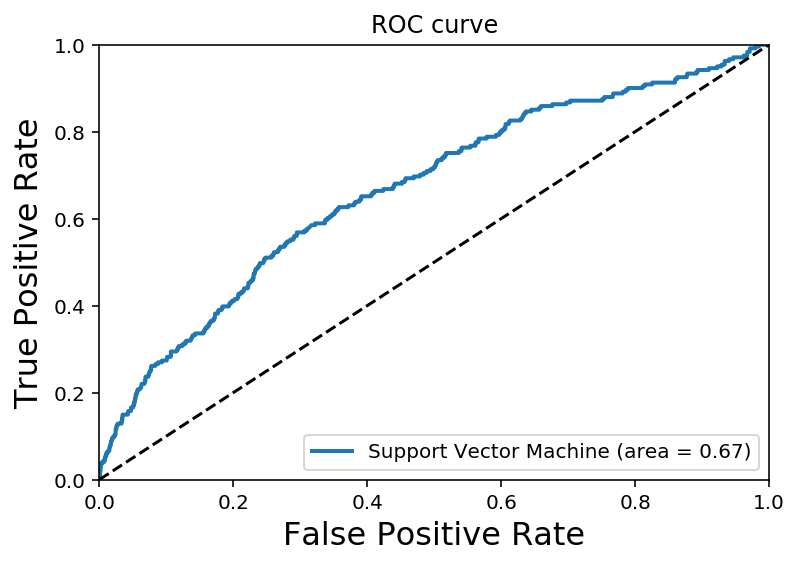

In [1675]:
plot_roc_curve(fpr, tpr, "Support Vector Machine")

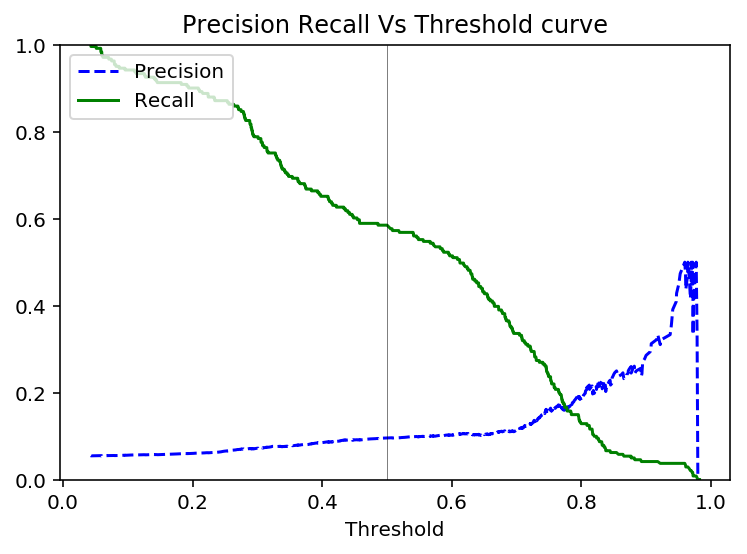

In [1676]:
precisions, recalls, thresholds = precision_recall_curve(y[test_index], pred_proba[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Logistic Regression


In [1628]:
Accuracy = []
Precision=[]
Recall=[]
F1 = []
AUC = []

lr = LogisticRegression(C=100.0, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001)   

kf = KFold(n_splits=3)                                                                                                 
for train_index, test_index in kf.split(Xs,y):
    smt = SMOTETomek(ratio = 'auto')
    X_train_smt, y_train_smt = smt.fit_sample(Xs[train_index], y[train_index])
    
    lr.fit(X_train_smt, y_train_smt) 
    
    pred = lr.predict(Xs[test_index])
    pred_proba = lr.predict_proba(Xs[test_index])  
    
    fpr, tpr, thresholds = roc_curve(y[test_index], pred_proba[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    conf_mat = confusion_matrix(y[test_index], pred)

    Accuracy.append(accuracy_score(y[test_index], pred))
    Precision.append(precision_score(y[test_index], pred))
    Recall.append(recall_score(y[test_index], pred))
    F1.append(f1_score(y[test_index], pred))
    AUC.append(roc_auc_score(y[test_index], pred_proba[:,1]))

In [1629]:
performance_metrics(Accuracy, Precision, Recall, F1, AUC)



Accuracy           67.36%
Precision          8.87%
Recall             59.08%
F1                 0.15
AUC                0.68


In [1630]:
# Logistic Regression result is quite good and similar to support vector machine


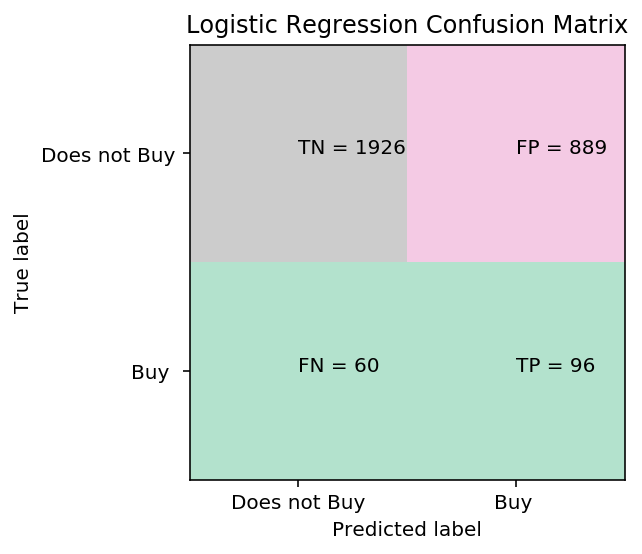

In [1640]:
plot_confusion_matrix(conf_mat, y[test_index], pred, "Logistic Regression")

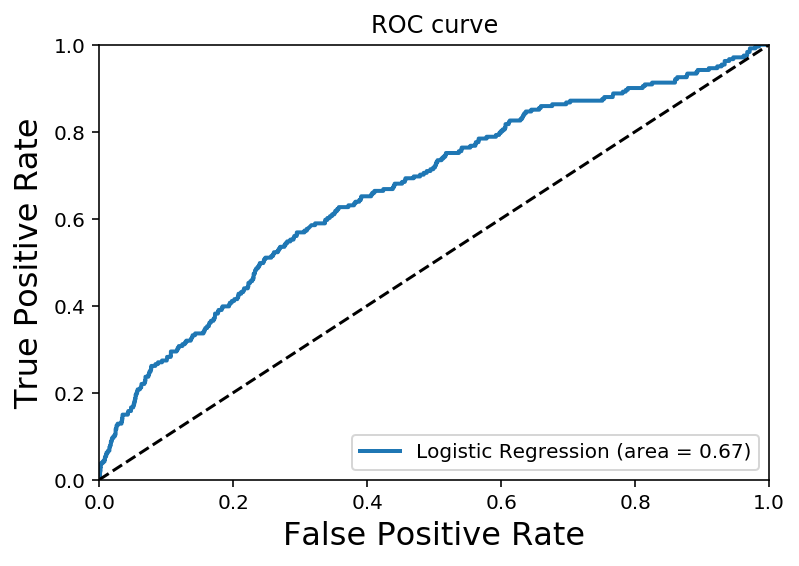

In [1678]:
plot_roc_curve(fpr, tpr, "Logistic Regression")


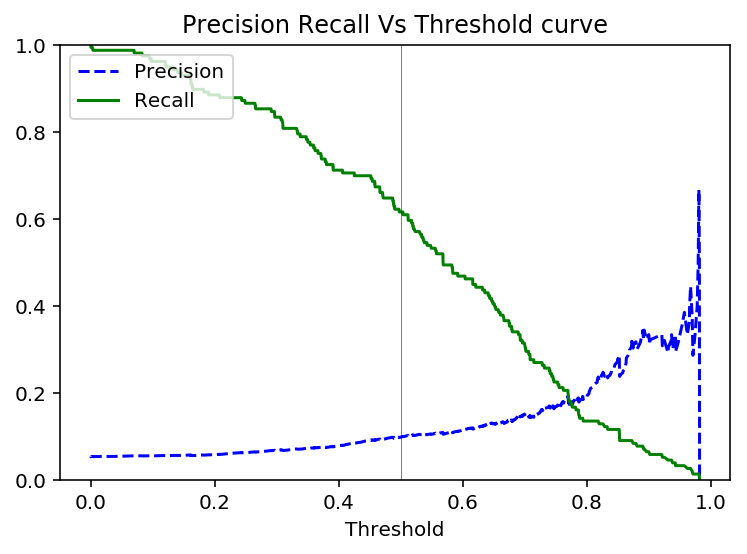

In [1644]:
precisions, recalls, thresholds = precision_recall_curve(y[test_index], pred_proba[:,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [1714]:
lr_coefs2 = pd.DataFrame(lr.coef_.ravel(), index= X.columns, 
                         columns = ['Coefficients']).sort_values('Coefficients', ascending = False)
lr_features = lr_coefs2.head(5)

In [1725]:
lr_features

,Coefficients
Master Degrees Holders,4.503346
motorcycle_insurance,4.242382
Young Seniors(45-65 yrs old),3.733349
fire_insurance,3.203415
car_insurance,3.145307


In [1724]:
lr_features = lr_features.rename({'subtype_17': 'Master Degrees Holders', 'subtype_25': 'Young Seniors(45-65 yrs old)'})


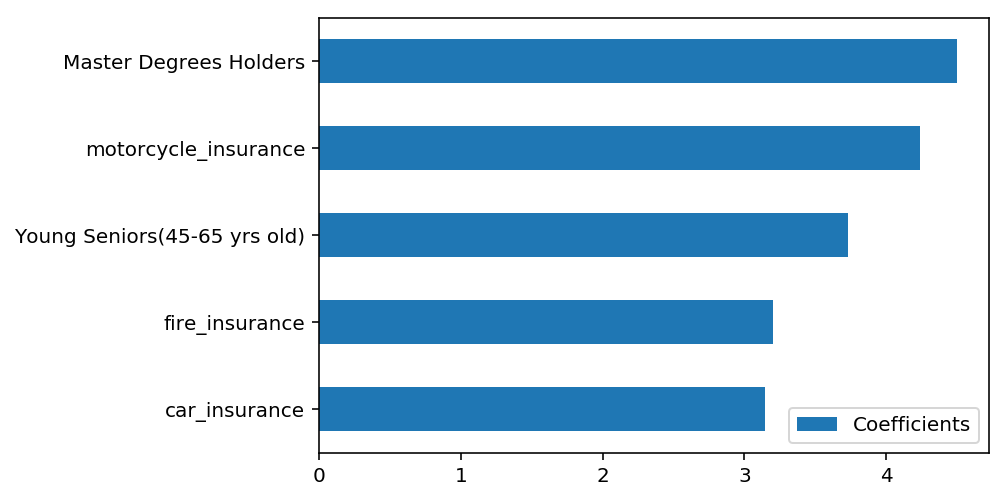

In [1727]:
lr_features.sort_values('Coefficients').plot(kind = 'barh')

# After running 5 models, the AUC score ranges between 65% to 70%, therefore i will be using recall and precision matrix to determine which is my best model. 

# Given that support vector machine and logistic regression has the same recall at 60% and precision at 8%, i conclude that logistic regression is my best model and it is better for interpretation.

# In a business concept, it is important to know whether a marketing campaign will be profitable or not, therefore I will be using Logistic Regression to do a cost and benefit evaluation.

In [1057]:
# I need to find the average premium amount to perfom the cost benefit evaluation, this is to
# impute the average premium range into the life insurance premium data.  
def premium_conversion(num):
    premium_dict= {0 : 0, 1 : (1 + 49)//2, 2 : (50 + 99)//2, 3 : (100+199)//2, 4 : (200+499)//2, 5 : (500+999)//2,
                  6 : (1000 +4999)//2, 7 : (5000+9999)//2, 8 : (10000+19999)//2, 9 : 20000}
    return premium_dict[num]



In [1058]:
df['life_premium']= df['life_premium'].apply(lambda x: premium_conversion(x))
life =df.loc[df['life_premium'] >0]

In [1059]:
average_premium = life['life_premium'].mean()
average_premium

753.1447661469933

In [1061]:
# This cost/benefit matrix will take into account the following:
#False positive- where my model predicted customer will buy the life insurance but in actual they dont.Marketing Cost
#False Negative - my model predicted customer will not buy but they do. This is oppotunity cost where the model
#               did not capture potential customer.
#True Positive - This is the number of customers predicted and they do buy. Higher this number, higher it will bring
#               revenue to the company.
FN_amount = -753
TP_amount = 753
TN_amount = 0
FP_amount = -30

calculate_profit(conf_mat, TN_amount, FN_amount, FP_amount, TP_amount)

138

In [1062]:
ranking_profit_log = create_ranking_profit_df("Logistic Regression", y[test_index], pred_proba)

In [1063]:
ranking_profit_log

,score,actual,profit,cummulative_profit
1953,0.981577,1,753,753
608,0.981531,0,-30,723
2585,0.980523,0,-30,693
2065,0.979152,1,753,1446
1351,0.976024,0,-30,1416
1706,0.974809,0,-30,1386
2068,0.972512,0,-30,1356
1454,0.969046,0,-30,1326
1748,0.968177,1,753,2079
1834,0.966370,1,753,2832


In [ ]:
# The cummulative profit has peaked at around $46000 with 1000 customers and start to decline with 
# increasing marketing cost.

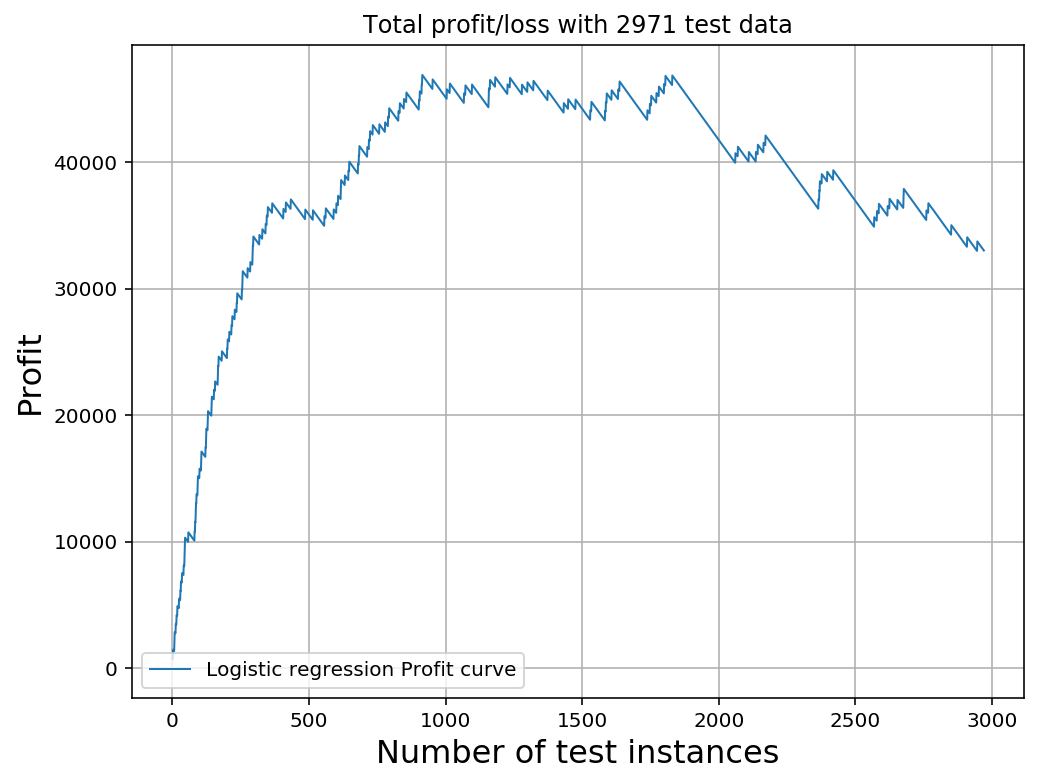

In [1729]:
plt.clf
plt.figure(figsize=(8, 6))
plot_profit_curve("Logistic regression", ranking_profit_log)
plt.title('Total profit/loss with 2971 test data')



plt.show()

# Grid Search for decision Tree

In [552]:
param_grid = {'max_depth': range(1,10,2), 'min_samples_leaf':  np.linspace(0.1, 1, 10), "min_samples_split": np.linspace(0.1, 0.5, 12),
              "min_samples_leaf": np.linspace(0.1, 0.5, 12)}

In [553]:
GS_dt= GridSearchCV(estimator = DecisionTreeClassifier(),param_grid= param_grid, cv= 3)



In [554]:
GS_dt.fit(X_train_smt, y_train_smt)
prediction = GS_dt.predict(X_test)
fpr, tpr, _= roc_curve(y_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.6355133376805123


In [555]:
GS_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}

# Grid Search for Random Forest

In [556]:
param_grid = {'max_depth': range(1,10,2), 'min_samples_leaf':  np.linspace(0.1, 1, 10), "min_samples_split": np.linspace(0.1, 0.5, 5),
              "min_samples_leaf": np.linspace(0.1, 0.5, 5), 'n_estimators' :[100, 300, 500], 'max_features':[10, 20, 30]}

In [557]:
GS_rf= GridSearchCV(estimator = RandomForestClassifier(),param_grid= param_grid, cv= 3, verbose = 1, n_jobs=-1)



In [558]:
GS_rf.fit(X_train_smt, y_train_smt)
prediction = GS_rf.predict(X_test)
fpr, tpr, _= roc_curve(y_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)


Fitting 3 folds for each of 1125 candidates, totalling 3375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 3375 out of 3375 | elapsed: 30.4min finished


0.6546421705003428


In [559]:
GS_rf.best_params_

{'max_depth': 7,
 'max_features': 10,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.2,
 'n_estimators': 500}

# Grid Search for K Nearest Neighbour

In [560]:
param_grid = {'n_neighbors':[5,7,9,11,13],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance']}

In [561]:
GS_knn = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, cv=3, n_jobs=-1, verbose = 1)

In [562]:
GS_knn.fit(X_train_smt, y_train_smt)
prediction = GS_knn.predict(X_test)
fpr, tpr, _= roc_curve(y_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.2min finished


0.5254337992537551


In [563]:
GS_knn.best_params_

{'leaf_size': 1, 'n_neighbors': 5, 'weights': 'distance'}

# Grid Search for SVC

In [574]:
param_grid = {'C':[1,10,100],'gamma':[1.5,1,0.1,0.001], 'kernel':['linear','rbf']}

In [575]:

GS_svc = GridSearchCV(SVC(), param_grid = param_grid, cv=3, n_jobs=-1, verbose = 1)

In [578]:

GS_svc.fit(X_train_smt, y_train_smt)
prediction = GS_svc.predict(X_test)
fpr, tpr, _= roc_curve(y_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)


In [ ]:
GS_svc.best_params_

# Grid Search for Logistic Regression

In [570]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag']}

In [571]:
GS_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid = param_grid, cv=3)


In [572]:
GS_lr.fit(X_train_smt, y_train_smt)
prediction = GS_lr.predict(X_test)
fpr, tpr, _= roc_curve(y_test, prediction)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.6211377526330639


In [573]:
GS_lr.best_params_

{'C': 1, 'solver': 'liblinear'}